In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Overview

![](https://files.realpython.com/media/Use-Sentiment-Analysis-With-Python-to-Classify-Reviews_Watermarked.e73ba441d870.jpg)
Sentiment Analysis is an application of Natural Language Processing (NLP) which is the process of detecting the emotional tone behind text, offering key insights into customer satisfaction.

In the era of social media, where communities leave their opinions and comments on the internet about various topics can be utilized as a powerful tool to optimize products according to their satisfaction.
Movie fanatics are spending hours scrolling and discussing movie reviews on social media like twitter,reddit,etc. expressing their views even before the movie is released. Sentiment Analysis allows us to deeply analyse these thoughts and views , allowing production houses and film makers to make final edits and touch ups before the release. <br>
Therefore,by maintaining customer satisfaction and meeting their requirements, the ROI generated tends to be higher naturally.


# 1. Loading Dataset and Initial Preprocessing 

## 1.1 Importing Required Dependencies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#NLP modules
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re,string,unicodedata
from nltk import ngrams
from bs4 import BeautifulSoup
from textblob import TextBlob
from textblob import Word

#Machine Learning modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score , f1_score
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 14 ,8
plt.style.use('ggplot')

## 1.2 Loading Dataset 

In [3]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
df.sample(2)

,review,sentiment
35654,Corben Bernsen directed horror film about a ch...,negative
2793,"Specks of white and various shapes, a beautifu...",negative


In [5]:
df.info() , df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


(None, (50000, 2))

In [6]:
df.duplicated().sum()

418

In [7]:
df=df.drop_duplicates(keep='first')


In [8]:
df.shape

(49582, 2)

In [9]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [10]:
#considering only first 20000 reviews 
df=df[:20000]
df.shape

(20000, 2)

In [11]:
df['sentiment'].value_counts()/df.shape[0] *100

negative    50.415
positive    49.585
Name: sentiment, dtype: float64

Very slightly imbalanced, therefore we dont need to take any further steps to address this issue.

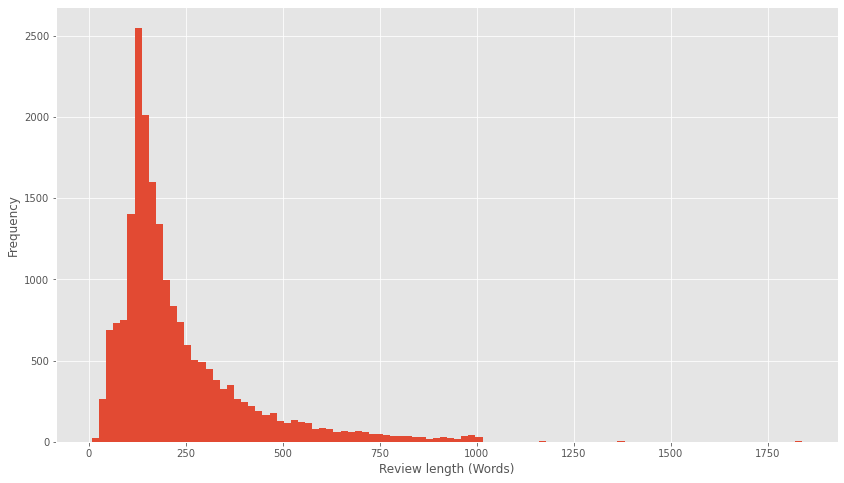

In [12]:
#Visualizing the frequency of words used in the reviews
words_per_review = df.review.apply(lambda x:len(x.split(" ")))
words_per_review.hist(bins=100)
plt.xlabel("Review length (Words)")
plt.ylabel("Frequency")
plt.show()

Most of the reviews have words between 0 and 500. While some even have upto a 1000 words.

In [13]:
print("Average words:" , words_per_review.mean())

Average words: 231.35425


# 2. EDA - Data Preparation
Text preprocessing and normalization is crucial before building a proper NLP model. Some of the most important steps are:
- Converting words to lower/upper case : one basic format 
- Removing special characters : such as ! @ #
- Removing stopwords and high/low frequency words : such as html variable like br
- Stemming/Lemmatization : all the verb of expressions are inteprated in the same way like eat,eating



## 2.1 Text Visualization 
WordCloud is a powerful tool to analyze the frequency of words and lets us visualize distributions of the words used in all of the reviews.

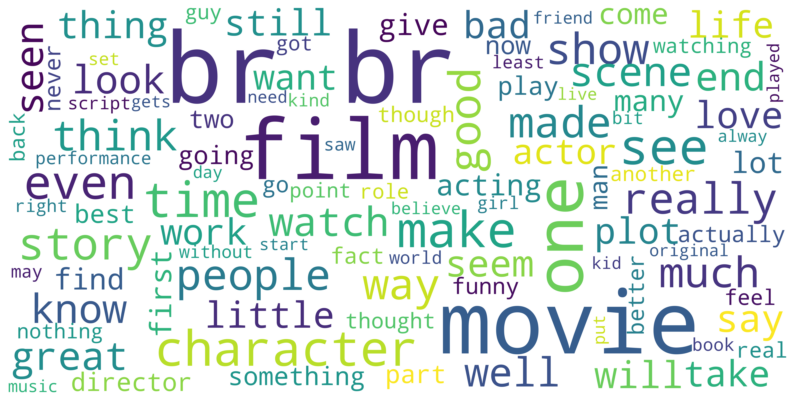

In [14]:
word_cloud_text = ''.join(df['review'])

wordcloud = WordCloud(max_font_size=100,
                      max_words=100,
                      background_color='white',
                      scale = 10, #scaling b/w computation and drawing
                      width = 800,
                      height = 400,
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,interpolation = 'bilinear') #make sure displayed image is smooth
plt.axis('off') #deleting axis because its not a plot
plt.show()

- Its not surprising that most people are talking about movies,films,scripts, plots, character, actor, shows.
- There are html terminologies like 'br' that we will have to take care of.

## 2.2 Converting all words to same case
I am going to convert all words to lower case , you can do upper case as well.

In [15]:
df['new_review']=df['review'].str.lower()

In [16]:
df.head(5)

,review,sentiment,new_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production. <br /><br />the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


## 2.3 Normalization and Word Tokenization
Using the word_tokenize function from the nltk library, we can extract unique characters from a sentence. <br>
For example :

In [17]:
word_tokenize("I fell in love with Mizuhara! Allow it, I know she 2D :(")

['I',
 'fell',
 'in',
 'love',
 'with',
 'Mizuhara',
 '!',
 'Allow',
 'it',
 ',',
 'I',
 'know',
 'she',
 '2D',
 ':',
 '(']

Had to divide the dataset in 2 batches as it was breaking the memory threshold on kaggle.

In [18]:
#For Reviews not converted to lower case - batch 1
token_list = [word_tokenize(each) for each in df['review']]
tokens = [item for sublist in token_list for item in sublist]
print(f'Number of unique tokens before: {len(set(tokens))}')

Number of unique tokens before: 118982


In [19]:
# #For Reviews not converted to lower case - batch 2
# token_list = [word_tokenize(each) for each in df['review'][25000:]]
# tokens_2 = [item for sublist in token_list for item in sublist]
# print(f'Number of unique tokens before: {len(set(tokens_2))}')

In [20]:
#For Reviews converted to lower case - batch 1
token_list = [word_tokenize(each) for each in df['new_review']]
tokens_lower = [item for sublist in token_list for item in sublist]
print(f'Number of unique tokens after: {len(set(tokens_lower))}')


Number of unique tokens after: 100884


In [21]:
# #For Reviews converted to lower case - batch 2
# token_list = [word_tokenize(each) for each in df['new_review'][25000:]]
# tokens_lower_2 = [item for sublist in token_list for item in sublist]
# print(f'Number of unique tokens after: {len(set(tokens_lower_2))}')


In [22]:
print(f"Total number of unique tokens when not converted to lower case: {len(set(tokens))}")
print(f"Total number of unique tokens when converted to lower case: {len(set(tokens_lower))}")
print(f"Percentage of tokens gone down after normalization of corpus : {len(set(tokens)) / len(set(tokens_lower))}")

Total number of unique tokens when not converted to lower case: 118982
Total number of unique tokens when converted to lower case: 100884
Percentage of tokens gone down after normalization of corpus : 1.179394155663931


## 2.4 Removing Special Characters 
This part of the preapartion is a subjective call. The main focus of this task is to analyse the underlying sentiment behind the words and some special characters like '!' can give us the degree of the postivity or negativity in a sentence for example: <br>
'I hate the main character's voice!!' The exclamation mark here gives us the idea that the user hates his voice on a higher degree. 

Otherwise, removing non emotionally charged characters such as commas(,) , semicolons(:) is likely safer.

In [23]:
#Listing the special characters that are not spaces
spl_chr = df['new_review'].apply(lambda review: 
                                 [char for char in list(review) if not char.isalnum() and char != ' '])
spl_chr_list = [item for sublist in spl_chr for item in sublist]
print(len(set(spl_chr_list)))
print(set(spl_chr_list))

63
{'-', '\\', '.', '\x9a', '&', '®', '|', '>', '/', '+', '~', '<', '’', '{', '·', '=', ',', '“', '\x84', '\x96', '”', '\x91', '§', '(', '‘', '▼', '^', '%', '"', '`', '@', '\x10', ';', '_', '\x85', '¡', '£', '´', '\x95', '[', '\x80', '\t', '¨', '*', '\xa0', '–', "'", '₤', ')', '?', '…', '}', ':', '«', '»', '¿', '¢', '#', '$', ']', '\x08', '!', '\x97'}


To keep this task simple, I am going to remove all the special character. Although , if the model is not performing well , it might be useful to come back to this and keep the emotionally charged ones.

We are going to use simple regular expressions to carry out this task. **Regular expressions** keep the parameters defined inside the brackets.

In [24]:
old_reviews = df['new_review'].copy()
df['new_review']=df['new_review'].str.replace(r'[^A-Za-z0-9 ]+' , ' ')

Therefore all characters in the reviews except :
- A-Z - captial alphabets 
- a-z - lower alphabets
- 0-9 - numbers
- ' ' -  white space

are replaced by a white space.

Below is an example:


In [25]:
print("- Old Review - ")
print(old_reviews.values[7])
print("\n- New Review - ")
print(df['new_review'][7])

- Old Review - 
this show was an amazing, fresh & innovative idea in the 70's when it first aired. the first 7 or 8 years were brilliant, but things dropped off after that. by 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />it's truly disgraceful how far this show has fallen. the writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. i find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. how can one recognize such brilliance and then see fit to replace it with such mediocrity? i felt i must give 2 stars out of respect for the original cast that made this show such a huge success. as it is now, the show is just awful. i can't believe it's still on the air.

- New Review - 
this show was an amazing  fresh 

## 2.5 Removing Stopwords and High/low frequency words
As adverbs and prepositions do not provide much specific insights, we tend to remove them from the reviews. The nltk library has a set of stopword list which contains all the words that can be considered as one . After comparing our reviews to that list, we remove the words that match the stopword list.

In [26]:
#printing the stop words in the English language
eng_stop_words = stopwords.words('english')
eng_stop_words


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

An example of removing the stopwords from a sentence.

In [27]:
#example
stop_words = set(eng_stop_words) #set to make sure the words are unique
without_stop_words = []
with_stop_words = []
sentence = df['new_review'][0]
words = nltk.word_tokenize(sentence) #extract every character in it

for word in words:
    if word in stop_words:
        with_stop_words.append(word) #adding the word in the stopword list
    else:
        without_stop_words.append(word)

print(f'Original sentence --- {sentence}')
print(f'\n Stopwords in the sentence ---{with_stop_words}')
print(f'\n Non-stopwords in the sentence ---{without_stop_words}')

        
            
        

Original sentence --- one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked  they are right  as this is exactly what happened with me br  br  the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word br  br  it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many aryans  muslims  gangstas  latinos  christians  italians  irish and more so scuffles  death stares  dodgy dealings and shady agreements are never far away br  br  i would say the main appeal of the show is due to t

In [28]:
#Defining a function to remove stopwords from all the reviews in the dataset 
def stopwords_remover(sentence):
    tokens = word_tokenize(sentence)
    tokens = [token.strip() for token in tokens] #removing any trailing spaces
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
df['new_review']=df['new_review'].apply(stopwords_remover)

In [29]:
df.head(2)

,review,sentiment,new_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...


In [30]:
#removing html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
df['new_review']=df['new_review'].apply(strip_html)

## 2.6 Lemmatization & Stemming
Some words are either singular or plural. Some words are reprsented in different tenses eg: eat,eating,ate. These syntactic differences between words formed are called **inflections**. In general,we want to treat these inflections similarly. 

**Stemming** -  works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** - takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

Although depending on the context and nature of the problem, it is important to choose the steps appropriately. eg: If you want to summarize a review of football in general, replacing **'Ronaldo'** with **'Casillas'** is fine, although it is a disaster for a striker analysis report.

Lemmatization can be costly when it comes to computational power. As our dataset is in general about movies and we are not targetting any particular franchise, We are just going to stem are reviews.

In [31]:
def simple_stemmer(text):
    ps=PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['new_review']=df['new_review'].apply(simple_stemmer)
df.head(5)

,review,sentiment,new_review
0,One of the other reviewers has mentioned that ...,positive,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,wonder littl product br br film techniqu unass...
2,I thought this was a wonderful way to spend ti...,positive,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...


# 3. Building a Machine Learning Model
As most of you might know, Machine Learning models do not understand words. Therefore we have to use some techniques so transform our features .

I was having a lot of computation issues with 50000 reviews. Therefore I am considering only the first 20000 reviews for my model processing  

## 3.1 n-grams
An n-gram is a contiguous sequence of n items from a given sample of text or speech. Instead of just considering a single world for our analysis , it is better to take words around it, or a block of words. These blocks are known as n-grams.

eg. 'Tom is a boy' Instead of considering 'Tom' [i.e n-gram range(1,1)] , it is better to analyse it as 'Tom is a boy' [i.e n-gram range(1,4)]

Advantages   : Retains structure , gives us some context <br>
Diadvantages : Major one , the dimension is vastly large. As the n-range increases the number of vectors increase, making computation very expensive.

In [32]:
sentence = 'Tom is a Boy'

for n in range(1, 5):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('Tom',), ('is',), ('a',), ('Boy',)]
2-grams:
 [('Tom', 'is'), ('is', 'a'), ('a', 'Boy')]
3-grams:
 [('Tom', 'is', 'a'), ('is', 'a', 'Boy')]
4-grams:
 [('Tom', 'is', 'a', 'Boy')]


## 3.2 Bag Of Words
The bag-of-words procedure falls under a broader category of techniques known as **count-based representations**. These are techniques to analyze reviews by indicating how frequently certain types of structures occur throughout. 

Basically we create a word-occurence matrix where 1 is represented as the word occurring in the review and 0 otherwise.

As for the n-gram range ,I am considering a 2 ngram range. Anything higher is breaking my RAM threshold. Please feel free to experiment on this if you have more computational power

In [33]:
#considering a n-gram range of 1 where a block of word would consist of 1 word
vec = CountVectorizer(tokenizer=word_tokenize,ngram_range=(1,2))
x = vec.fit_transform(df['new_review'])
ft_df = pd.DataFrame(x.toarray(), columns = vec.get_feature_names())


In [39]:
ft_df.sample(2)

,0,0 0,0 00001,0 02,0 1,0 10,0 2,0 3,0 4,0 5,...,zzzzzzzzzzzz one,zzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzz imdb,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz 8,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz 8,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz 8
1678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


more than million different features. This is a very highly dimension.

As we have handled the features for the model, similarly we convert the target column 'sentiment' into binary representation using the LabelBinarizer function.

In [36]:
lb=LabelBinarizer()
y = lb.fit_transform(df['sentiment'])
y.shape 

(20000, 1)

In [37]:
df_y = pd.DataFrame(y)
df_y.value_counts()


0    10083
1     9917
dtype: int64

In [40]:
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(x, # Features
                                                                    y, # Target variable
                                                                    test_size = 0.1, # 20% test size
                                                                    random_state = 0,
                                                                    stratify=y) 


## 3.2.1 Applying Logistic Regression
To keep this task on the simple side, I am just going to be using Logistic Regression to approach this task. If you have a better PC and dont mind waiting longer, please feel free to apply different ML algorithms such as Naive bayes, SGD ,  xGBoost , etc. 

In [41]:
### Training the model 
lr_model_bow = LogisticRegression(penalty='l2',max_iter=500,C=1) # Logistic regression
lr_model_bow.fit(x_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
y_pred_lr_bow = lr_model_bow.predict(x_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, y_pred_lr_bow))
print("Accuracy score:",accuracy_score(y_test_bow, y_pred_lr_bow))

F1 score:  0.9034175334323923
Accuracy score: 0.9025


In [42]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test_bow,y_pred_lr_bow,target_names=['Positive','Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.92      0.89      0.90      1008
    Negative       0.89      0.92      0.90       992

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [43]:
cf = confusion_matrix(y_test_bow,y_pred_lr_bow )
cf

array([[893, 115],
       [ 80, 912]])

<AxesSubplot:>

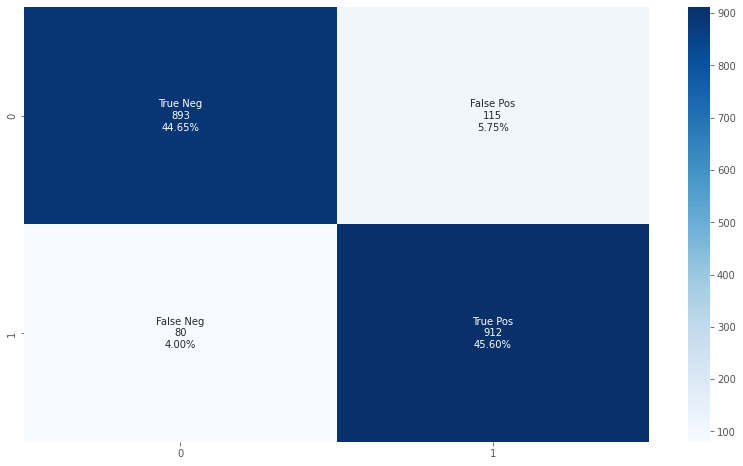

In [44]:
#visualizing the confusion matrix
cf = confusion_matrix(y_test_bow,y_pred_lr_bow )
group_names = ['True Neg' , 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

This is a very positive result. As almost 90% of the results were predicted accurately. Although this is with the reduced dataset. Considering all of the dataset might change the results. (Probably will)

We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment:

In [47]:
lr_weights = pd.DataFrame(list(zip(vec.get_feature_names(), # get all the n-gram feature names
                                   lr_model_bow.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
401369,excel,1.311755
14058,7 10,1.133013
14053,7,1.103460
14823,8,1.049039
556438,hilari,1.045031
423578,fantast,1.028367
14829,8 10,0.970393
162569,brilliant,0.968108
868277,perfect,0.958978
55627,amaz,0.932825


These are the top 15 words that have contributed the most towards the positive scores. The numbers 7 , 8 out of 10, I assume are probably ratings and this makes sense as they are on the higher side of the scale.

In [48]:
# top-15 more important features for negative reviews
lr_weights.sort_values(['weights'], ascending = False)[-15:] 

,words,weights
416987,fail,-0.938733
1239804,unless,-0.958432
605371,insult,-0.973422
369014,embarrass,-1.028783
351565,dull,-1.060726
1172697,terribl,-1.074568
10452,3 10,-1.094032
327633,disappoint,-1.143625
568189,horribl,-1.153787
1313416,wors,-1.188740


We can see a lot of negative remarks and also ratings such as 3/10 or 4/10.

# 4. Other NLP Methods 
Unfortunately due to my lack of computational power and my Kaggle RAM threshold reaching its limits (the red bar is very intimidating!!! ) , I will have to finish my work here. <br>
Before leaving I would like to give some more information about other NLP approaches that may prove to be better depending upon the nature of the problem and what hardware you are working with. 

Some alternatives for featurizing text inputs are:

1. TF-IDF Model : This evaluates how important a word is to a review within a large collection of review (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.It's a relatively simple but intuitive approach to weighting words . (Note : I have used it on a different pc and the results are pretty similar to the bow model.) Although it a more interpretable way of featurizing and is probably the right approach to this solution.

2. Words Embedding Model : This is a type of word representation that allows words with similar meaning to have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. It is capable of capturing the context of a word in a document, its semantic and syntactic similarity, and its relation with other words. Basically grouping words of similar nature together.For example bathroom, kitchen, bathtub are grouped together whereas cars,trains,aeroplanes are grouped together. There are different ways to learn word embeddings like GloVe , UMAP , Spectral Embedding and FastText, I like using transfer learning methods to load pre trained models and experiment on them. 

Please do give the above 2 methods a try. A lot of information is available on the internet regarding this,

# 5. Concluding Remarks
In this case, we cleaned up and featurized a Movie reviews dataset and built a classification models on these featurizations to predict sentiment wether it was positive or negative.

Please note that building machine learning models on text is a very involved discipline and some factors should be considered when working on real world problems , in our case major prodcution houses and film makers need to be absolutely sure before taking any major decisions. Some important factors to consider are:
1. Upper Case - In some cases , just like some special characters, upper cased words may contain emotonal weight. so it might be useful to consider them during data preparation .

2. Hyperparameter tuning in machine learning models is a very important step. We can't go ahead training a model with default parameters. Different sets of parameters have to be tried to see what contributes to the best model. Also applying cross validation steps.

Even though every NLP task is different ,the process to be followed is similar to what we did in this case: manipulate the data → create features from text → train ML models.

This is one of the biggest ways to analyse customer satisfaction and provide optimized products inturn generating geater ROI's.